# Spike-Timing Dependent Plasticity (experiment)

    Two intracellular electrodes were used (one for stimulation, one for measurement of the neuronal response).
    Excellent spatial and temporal resolution.
    Synaptic weight change ( ∆ w ji ) turns out to be a function of (t-j-f − t-i-f) .
    The direction of the change depends on the relative timing of pre-and postsynaptic spikes.

# Pair-based STDP learning rule

### STDP learning rule:
    The change in weight of a synapse depends on the temporal difference |∆ t | = | t-post − t-pre | :
        ∆ w + = A + ( w ) · exp(−|∆ t |/τ + ) at t-post        for  (t-pre < t-post)
        ∆ w − = A − ( w ) · exp(−|∆ t |/τ − ) at t-pre         for  (t-pre < t-post)
        
    Happens immediately after each spike (at times t pre and t post ). 
    This rule is fully specified by defining:
       (i) the weight-dependence of the amplitude parameter A ± ( w ) .
       (ii) which spike pairs are taken into consideration (all pairs or nearest one).
 

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from random import gauss
from random import randint
from random import random
import scipy.sparse as sparse
import scipy.stats as stats

In [2]:
delta_W = []          #save the changing of synapse weight [∆ w]
delta_T = []          #save the |∆ t | = | t-post − t-pre | 
def pairbasedSTDP(I_init, gl, Cm, num, T1 , T2 ):
    ######### Constants
    U_rest      =   -0.065                  # restint membrane potential [U]
    U_reset     =   -0.065
    thresh  =   -0.050                      # spiking threshold [U]
    tau =  Cm/gl                            
    A_plus = 2                              #amplitude parameter A ± ( w ) ,we consider this constant!
    A_neg = -2
    tau_t = 0.005                           #tau for stdp rule

    ######### Setup
    # TIME
    T       =   0.100                       # total simulation length [s]
    dt      =   0.00002                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    
    # VOLTAGE
    U_Pre       =   np.empty(len(time))    # array for saving Voltage history [pre and post neurons]
    U_Post      =   np.empty(len(time))
    
    U_Pre[0]    =   U_rest               # set initial to resting potential
    U_Post[0]   =   U_rest
    
    # CURRENT
    I_init = I_initial(I_init=I_init, time=time,num = num)
    I = np.zeros((2,len(time)))

    ######### Measurements
    spikes_Pre = [0]         # save the time of neuron's spike
    spikes_Post = [0]
    W = weights()            #set weights for the connection
    cnt=0
    ######### Simulation
    for i in range(len(time)-4):
            #compute current
            I[0,i]= I_init[i]*bool(i > T1) + I[0,i]
            I[1,i]= I_init[i]*bool(i > T2) + I[1,i]
            # use " tau.(du/dt) = -(U(t) -U_rest) + R.I(t))" to get this equation
            U_Pre[i] = (((U_rest - U_Pre[i-1]) + I[0][i]/gl)*dt)/tau + U_Pre[i-1]
            U_Post[i] = (((U_rest - U_Post[i-1]) + I[1][i]/gl)*dt)/tau + U_Post[i-1]
                 
            # in case we exceed threshold for pre and post neuron
            if U_Post[i] > thresh:
                U_Post[i-1] = 0.04          # set the last step to spike value
                U_Post[i] = U_reset         # current step is resting membrane potential
                spikes_Post.append(time[i]) # count spike
                #use  "∆ w + = A + ( w ) · exp(−|∆ t |/τ + ) at t-post" to get this equation
                delta_T.append((spikes_Post[-1] - spikes_Pre[-1]))
                delta_W.append((A_plus*math.exp(-1*abs(delta_T[-1])/tau_t)))
                W[0][1] += delta_W[-1]
                cnt+=1
                add_amount = I_values(1,i,I_init,time,spikes_Pre,W)
                I[:,i+1:i+5] = I[:,i+1:i+5] + add_amount
                
            if U_Pre[i] > thresh:
                U_Pre[i-1] = 0.04          # set the last step to spike value
                U_Pre[i] = U_reset         # current step is resting membrane potential
                spikes_Pre.append(time[i]) # count spike
                #use "∆ w − = A − ( w ) · exp(−|∆ t |/τ − ) at t-pre " to get this equation
                delta_T.append((spikes_Post[-1] - spikes_Pre[-1]))
                delta_W.append((A_neg*math.exp(-1*abs(delta_T[-1])/tau_t)))
                W[1][0] += delta_W[-1]
                cnt+=1
                add_amount = I_values(0,i,I_init,time,spikes_Post,W)
                I[:,i+1:i+5] = I[:,i+1:i+5] + add_amount
                
    return delta_W, delta_T, spikes_Pre, spikes_Post, cnt

#compute the initial current
def I_initial(I_init=0.005, time=None, num = 1):
    I0 = np.zeros(len(time))
    I0[0:4999] = I_init
    I1 = []
    I2 = []

    #Setting the initial current_ I1 
    for i in range(0, len(time)):
        
        var = gauss(I_init,I_init*0.1)
        I1.append(var)
    
    #Setting the initial current_ I2
    for i in range(0, len(time)):
        
        var = ((math.cos(i/100)+1)/4)*((math.sin(i/300)+1)/4)*(gauss(0,0.4*I_init))+I_init
        I2.append(var)
   
    I = [I0,I1,I2]
    return I[num-1]


#compute the effect of presynaptic neuron's spike to their postsynaptic neurons!            
def I_values(j=0,i=0,I_init = 0.05, time=None, spikes=None, W=None ,tau_I=0.001):
    #use w_ji*epsilon(s) where epsilon(s) = (s/tau).exp(1-(s/tau)) ;s=t - t_spike > 0
    exp1= (time[i+1:i+5] - spikes[-1])/tau_I
    exp2= np.exp(1-exp1)
    exp3= exp1*exp2
    I_inp = np.dot(W[j,:].reshape(2,1),exp3.reshape(1,4))
    return I_inp


#compute the weights of connectivity due to type of connectivty!
def weights():
    
    w = np.zeros((2,2))
    w[:,:] = abs(np.random.normal(6,4,size=(2,2)))/10
    for i in range(2): w[i,i]=0
    return w    
        
    

In [3]:
def simul_STDP(I_init ,gl_init ,Cm_init, num , time1, time2):
    delta_W, delta_T, spike_Pre, spike_Post, cnt= pairbasedSTDP(I_init, gl_init, Cm_init, num, time1, time2)
    delta_W = np.array(delta_W)
    delta_T = np.array(delta_T) 
    event = [spike_Pre,spike_Post]
    zero_t = np.zeros(len(delta_T))
    zero_w = np.zeros(len(delta_W))
    final = len(delta_W)
    
    ###ploting
    axis_color = 'lightgoldenrodyellow'
    fig = plt.figure("current", figsize=(12, 4))
    plt.title("spike raster plot")
    plt.eventplot(event , color = [[0, 0, 1],[1, 0, 1]])
    plt.ylabel("Neuron")
    plt.xlabel("Spike - Time [s]")
    
    
    fig = plt.figure("Population activity of neurons", figsize=(12, 8))
    plt.title("∆t = t-post − t-pre")
    plt.scatter(delta_T[-cnt:final],delta_W[-cnt:final], marker='o', s=10, c='blue',label="new results")
    plt.scatter(delta_T[0:-cnt],delta_W[0:-cnt], marker='o', s=10, c='magenta',label="old results")
    plt.plot(delta_T,zero_t,':r')
    plt.plot(zero_w,delta_W,':r')
    plt.ylabel("∆w")
    plt.xlabel("Time-difference [s]")
    plt.legend()
    
    
    

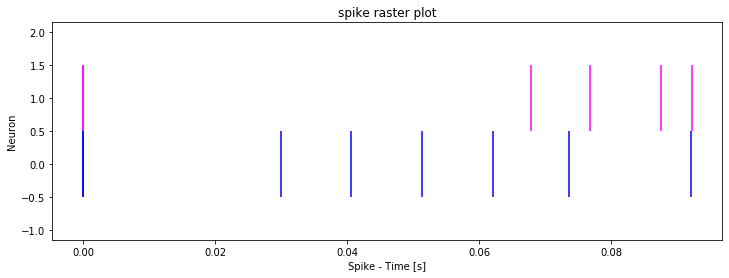

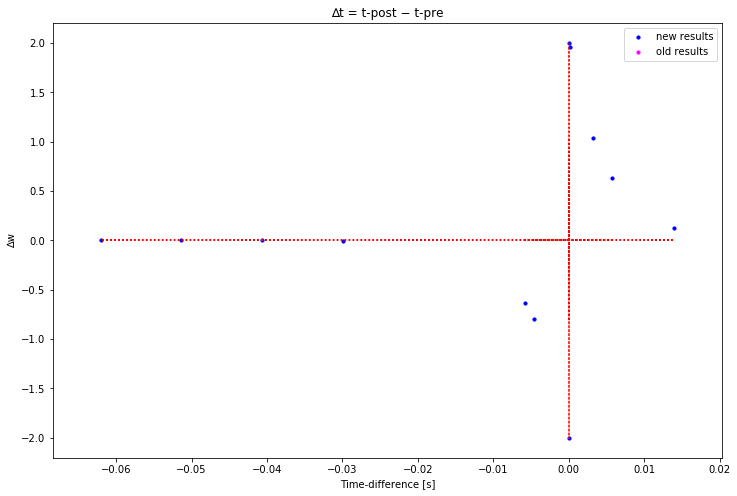

In [34]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 1000, 3000)

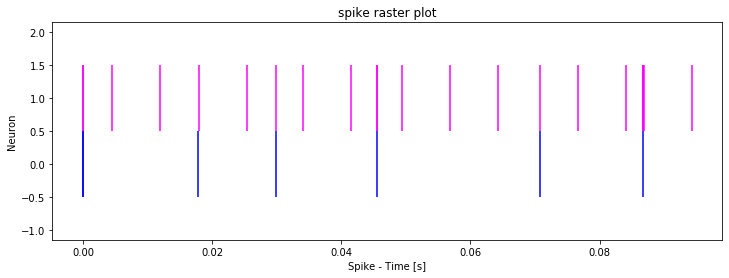

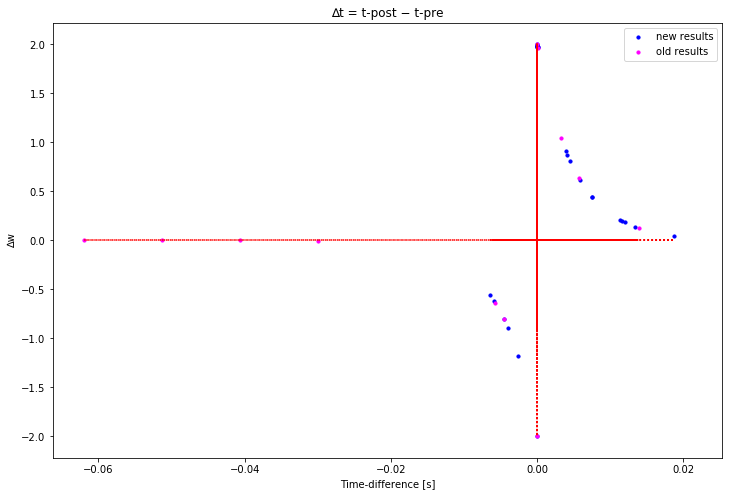

In [35]:
simul_STDP(0.01 ,0.016,0.0049 ,1 , 500 , 20)

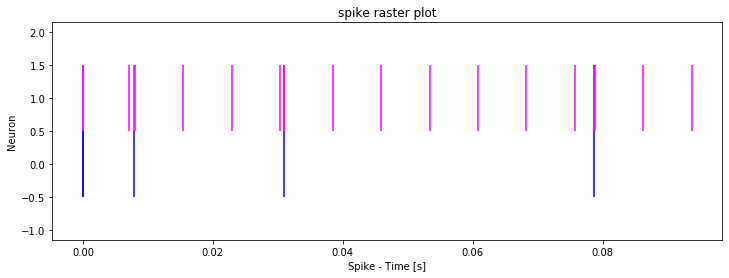

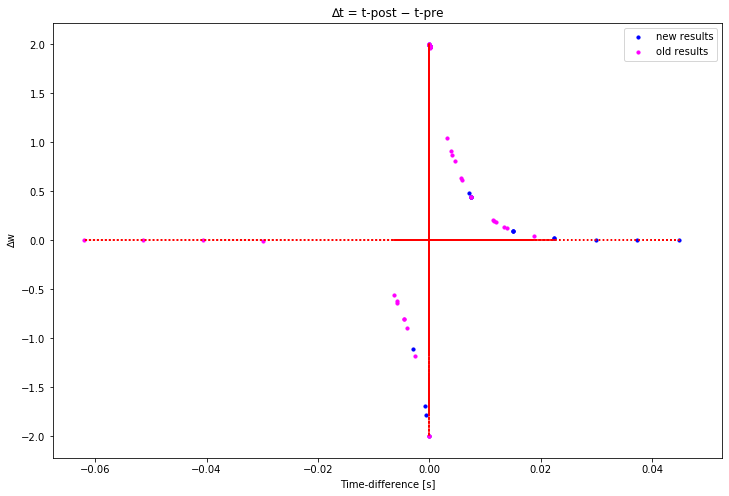

In [36]:
simul_STDP(0.01 ,0.016,0.0049 ,3, 10 , 100)

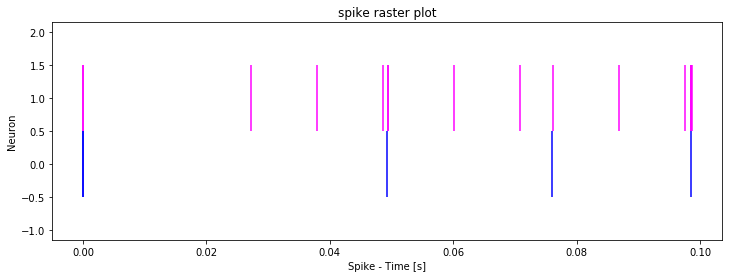

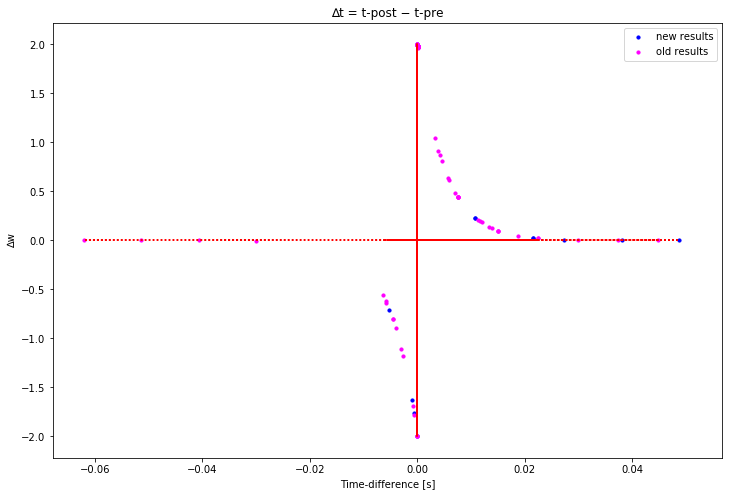

In [37]:
simul_STDP(0.007 ,0.016,0.0049 ,1 , 2000 , 1000)

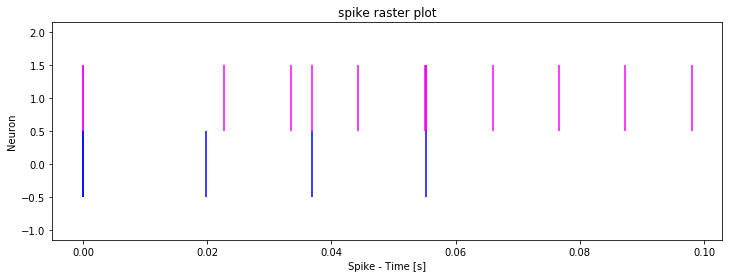

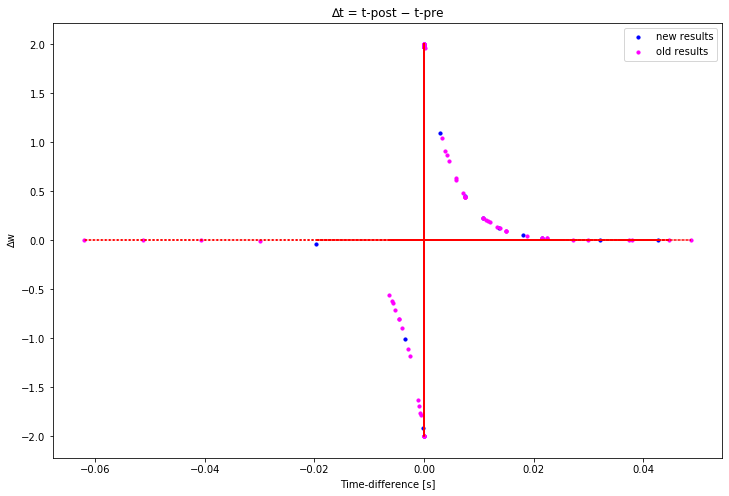

In [38]:
simul_STDP(0.007 ,0.016,0.0049 ,2 , 500 , 800)

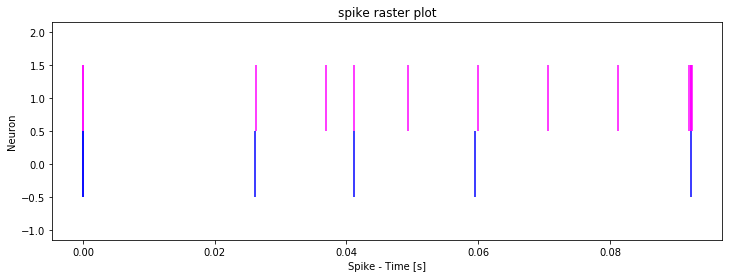

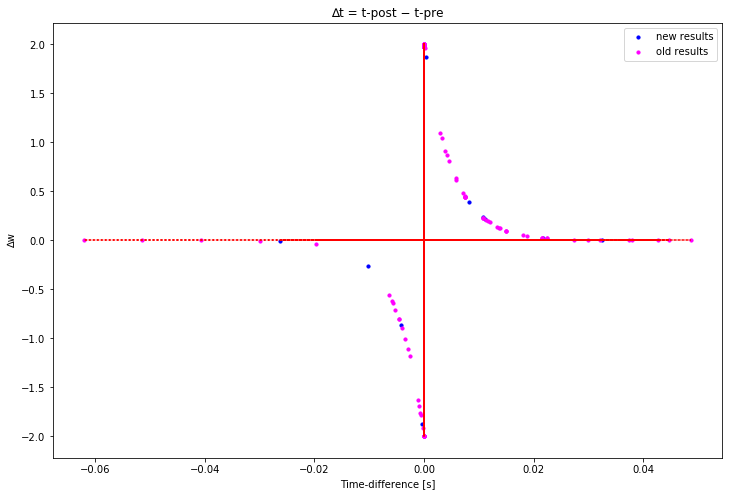

In [39]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 800 , 1000)

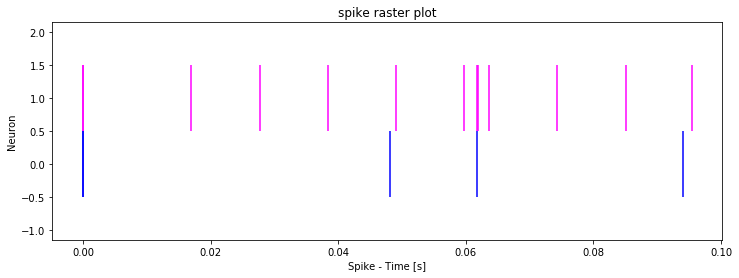

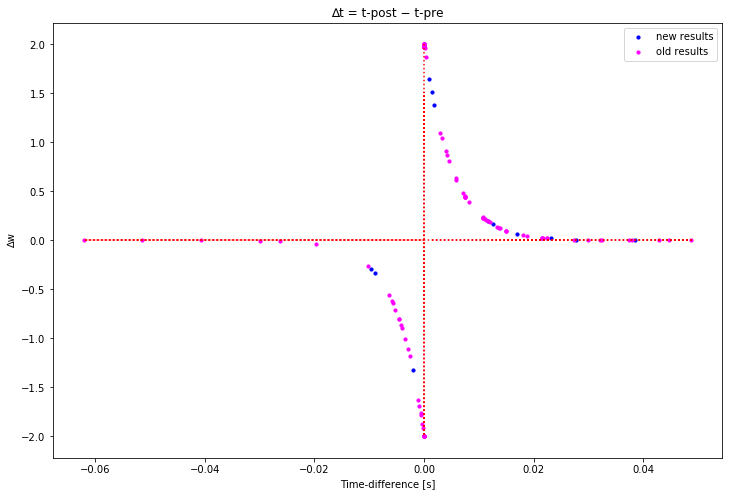

In [40]:
simul_STDP(0.007 ,0.016,0.0049 ,1 , 2000 , 500)

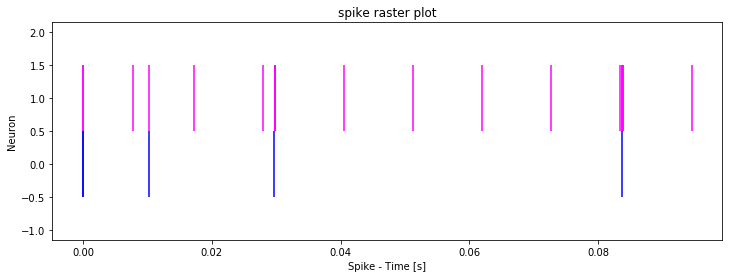

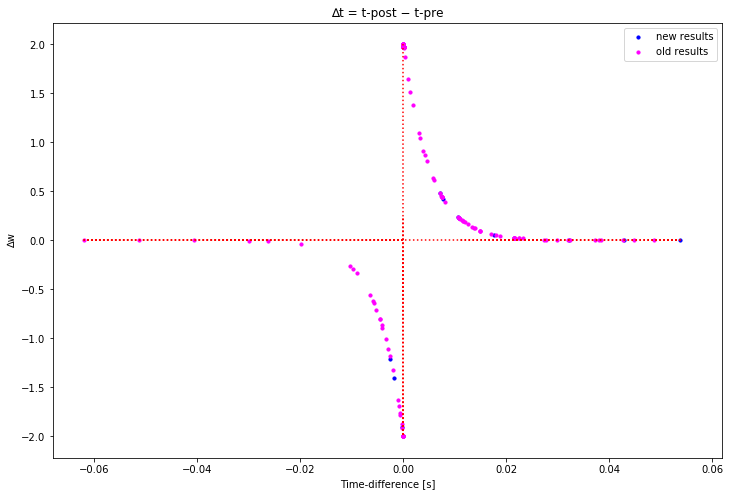

In [41]:
simul_STDP(0.007 ,0.016,0.0049 ,2 , 0 , 0)

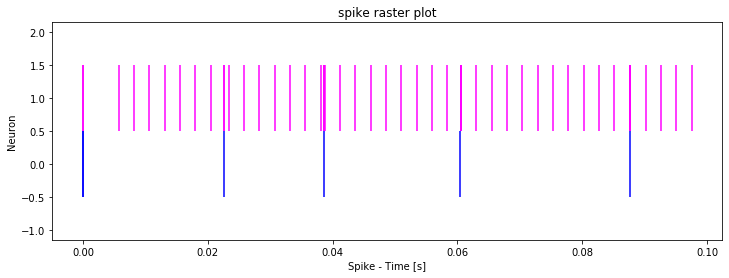

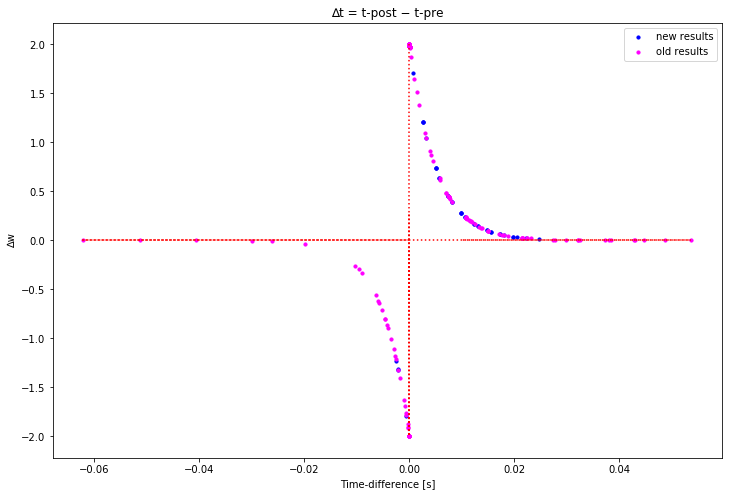

In [42]:
simul_STDP(0.03 ,0.016,0.0049 ,1 , 1000 , 200)

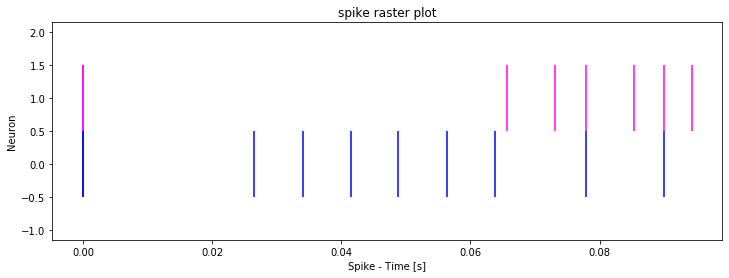

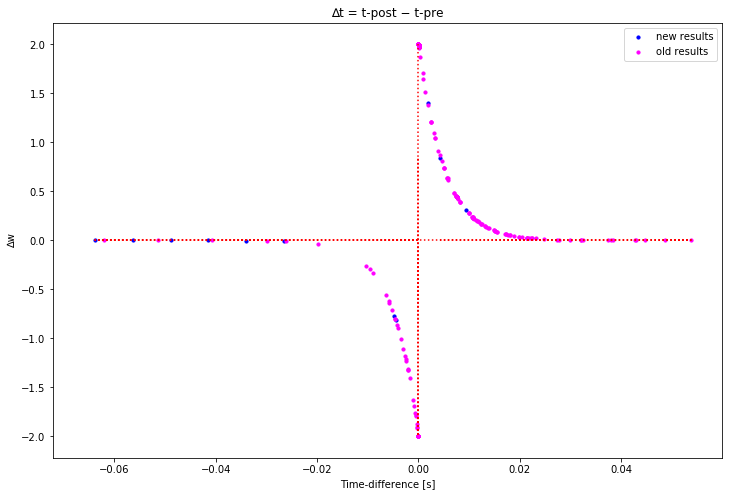

In [43]:
simul_STDP(0.01 ,0.016,0.0049 ,2 , 1000 , 3000)

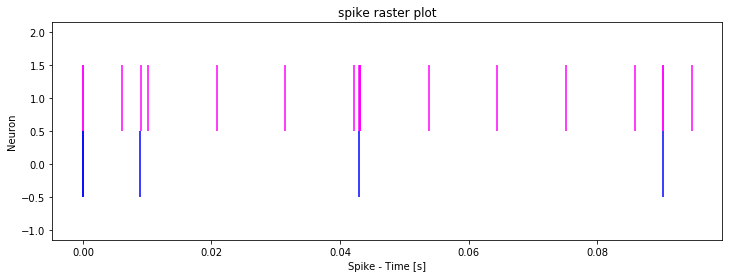

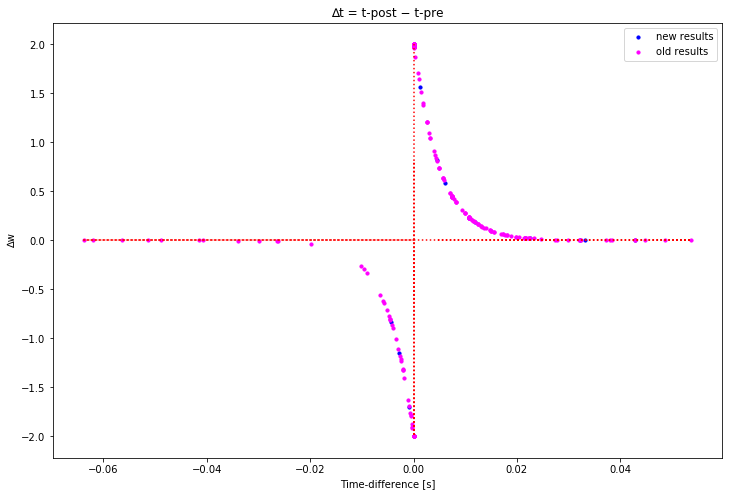

In [44]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 0 , 0)

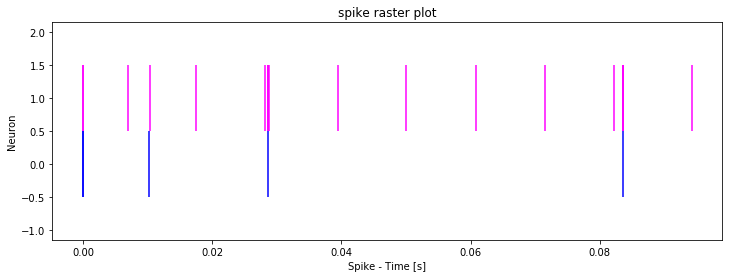

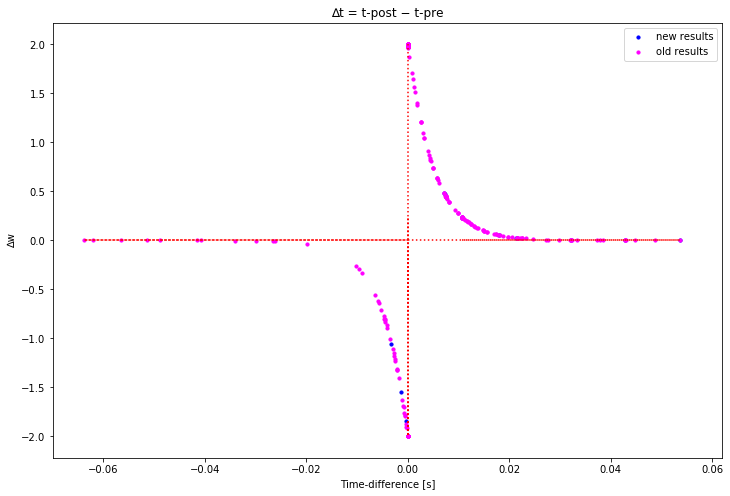

In [45]:
simul_STDP(0.007 ,0.016,0.0049 ,2 , 10 , 50)

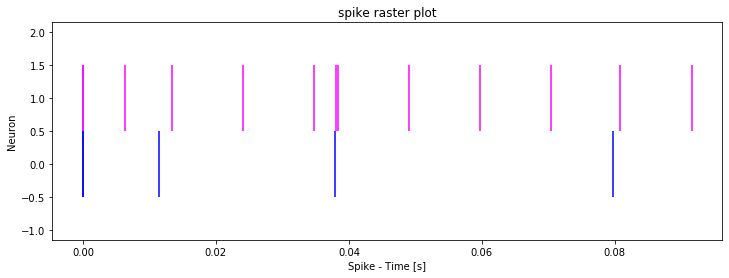

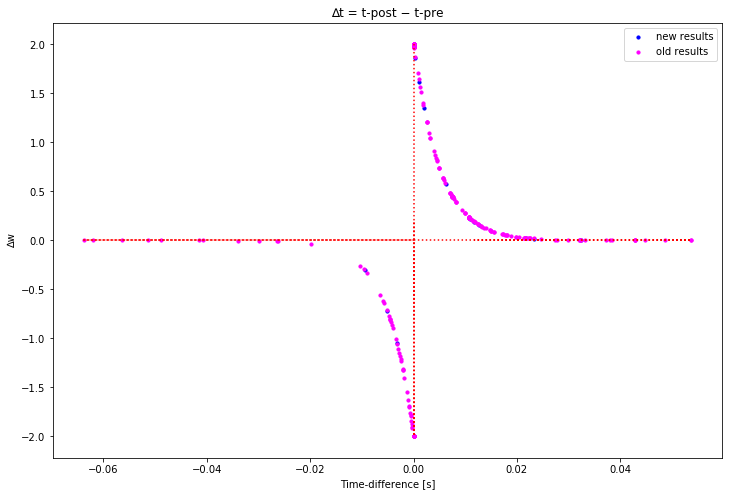

In [46]:
simul_STDP(0.007 ,0.016,0.0049 ,2 , 70 , 30)

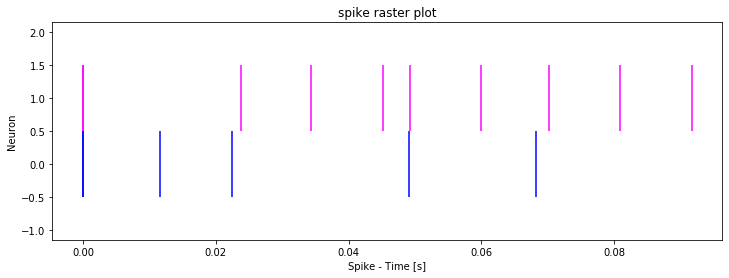

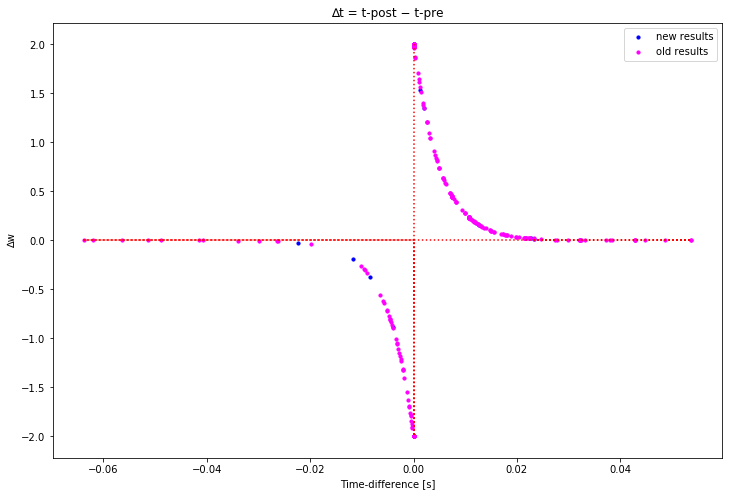

In [47]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 100 , 800)

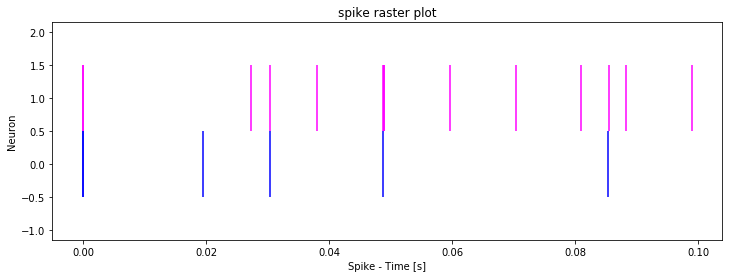

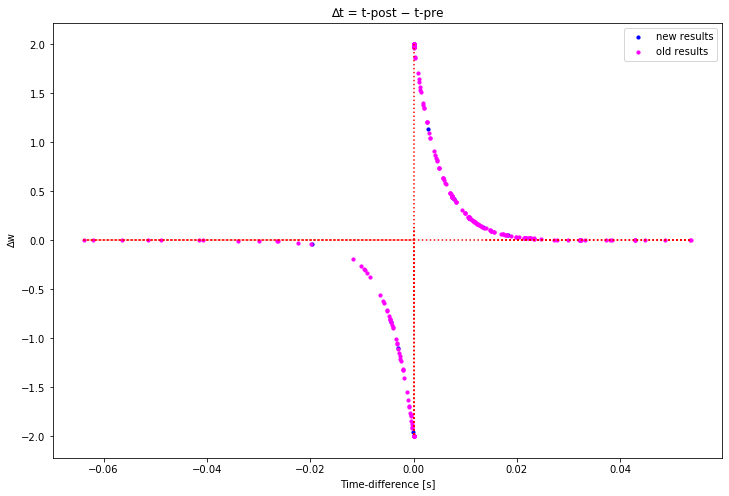

In [48]:
simul_STDP(0.007 ,0.016, 0.0049, 1, 490, 1000 )

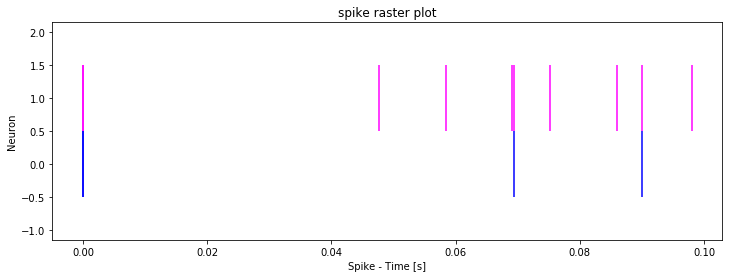

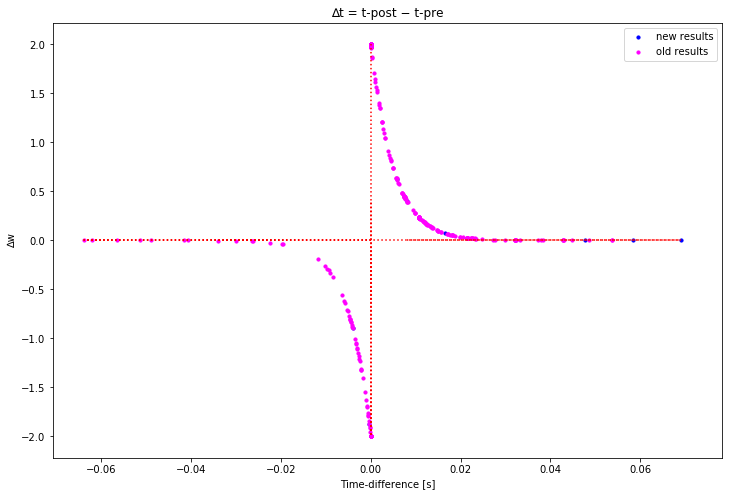

In [49]:
simul_STDP(0.007 ,0.016,0.0049 ,1 ,3000 , 2000)

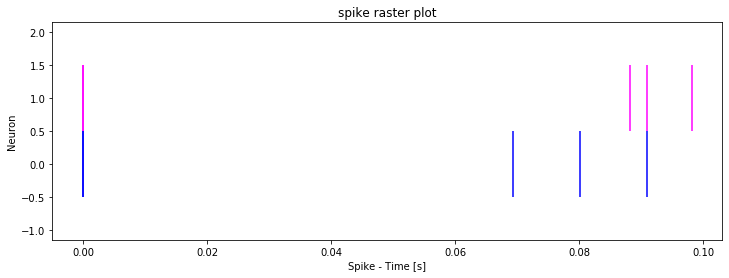

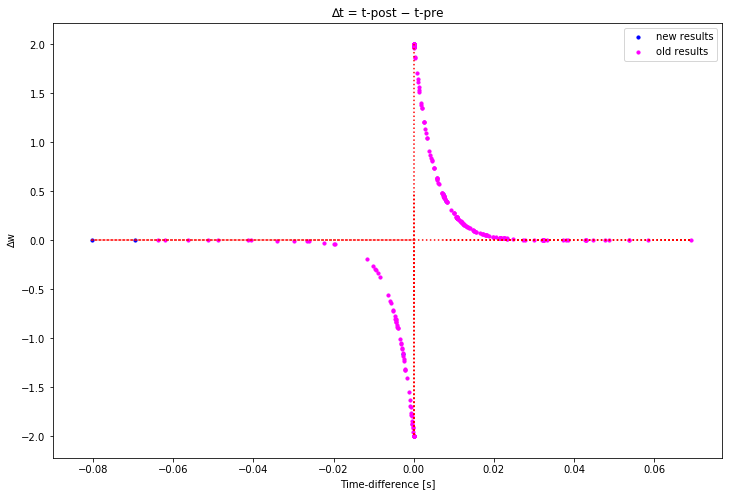

In [50]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 3000 , 4000)

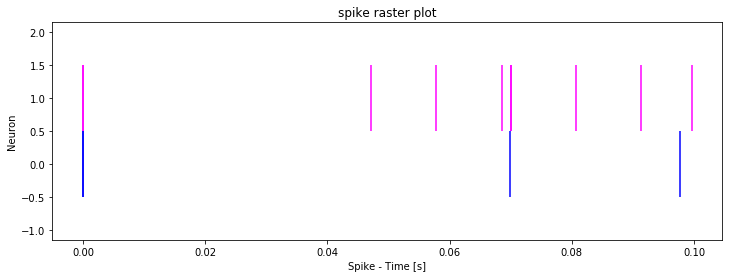

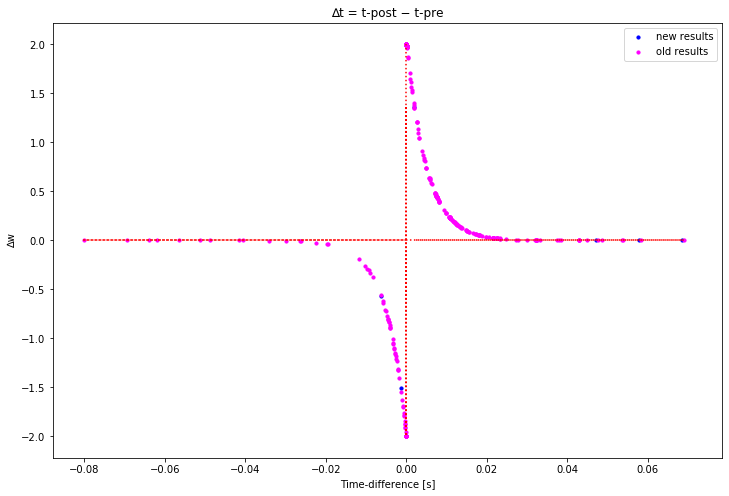

In [51]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 3000 , 2000)

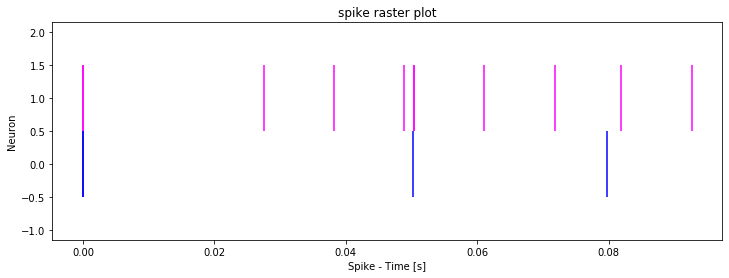

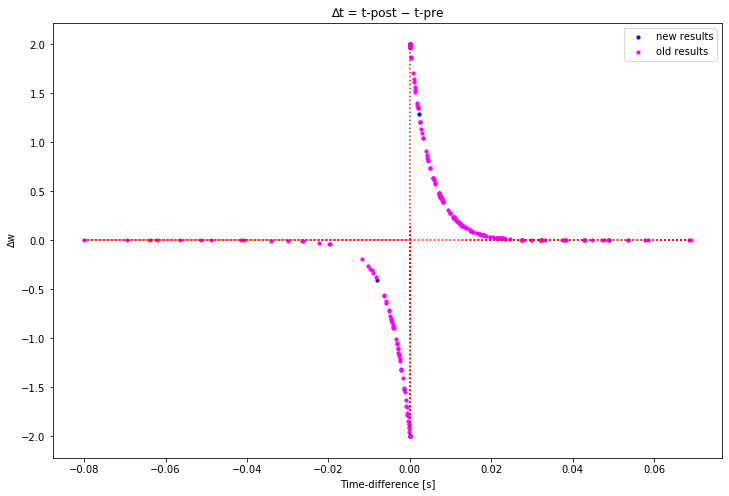

In [52]:
simul_STDP(0.007 ,0.016,0.0049 ,3 , 2000 , 1000)

Each time we activate the neurons at different time intervals so that they spike, then we save their weight changes. Each time we show the new weight changes related to the two given neurons in blue and the previous ones in pink. So that after repeating this operation several times, the dots form the desired diagram.


Sharare Zolghadr (610395109)                                                               
Computational Neuroscience